In [30]:
%matplotlib inline
import numpy as np
from sklearn.covariance import empirical_covariance

from regain.utils import structure_error
from regain import datasets
from regain.covariance.missing_multiple_graphical_lasso import MissingMultipleGraphicalLasso
from regain.covariance.latent_time_graphical_lasso_ import LatentTimeGraphicalLasso
from regain.covariance.time_graphical_lasso_ import time_graphical_lasso
from sklearn.impute import SimpleImputer
from sklearn.datasets.base import Bunch
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
# config
np.random.seed(0)
n_samples = 100
T = 3
beta = 1
from regain.datasets.multi_class import make_multiclass_dataset
from tqdm import tqdm

In [ ]:
kernel = np.zeros((T, T))
for i in range(T-1):
    kernel[i, i+1] = beta

results = {}

for n_dim_obs in   tqdm(np.logspace(2, 2.5, 3)):
    res_mmgl = []
    res_mmgl2 = []
    res_inputing = []
    res_inputing2 = []
    n_dim_obs = int(n_dim_obs)
    original_data = []
    
    alpha = np.log(n_dim_obs)/n_samples
    tau = 2*np.sqrt(n_dim_obs/n_samples)
    n_dim_lat = int(0.2*n_dim_obs)
    for i in range(10):
        mgl = MissingMultipleGraphicalLasso(alpha=alpha, kernel=kernel, psi='laplacian', 
                                        tol=1e-3, rtol=1e-3, verbose=0, max_iter=500)
        
        samples, _= make_multiclass_dataset(
                    n_samples=n_samples, n_dim_obs=n_dim_obs, n_classes=3)
        dataset = samples['gaussian']
        original_data.append(dataset.X)
        to_remove = int(T*n_samples*n_dim_obs*0.2)
        X = dataset.X
        X_ = np.array([X[dataset.y == cl] for cl in np.unique(dataset.y)])
        X[np.random.choice(np.arange(0, T*n_samples), to_remove),
          np.random.choice(np.arange(0, n_dim_obs), to_remove)] = np.nan
        X__ = np.array([X[dataset.y == cl] for cl in np.unique(dataset.y)])
        
       
        results_static = mgl.fit_transform(X, dataset.y)
        res_mmgl.append(np.linalg.norm(results_static - X_)**2/np.linalg.norm(X_)**2)
#         X_mean = X__.copy()
#         for i in range(T):
#             for j in range(X_mean[i].shape[1]):
#                 nans = np.where(np.isnan(X_mean[i, :, j]))
#                 X_mean[i,nans, j] = mgl.mean_[i][j]
            
#         res_mmgl2.append(np.linalg.norm(X_mean - X_)**2/np.linalg.norm(X_)**2)
        
        imp = np.array([SimpleImputer(strategy='mean').fit_transform(X[dataset.y == cl])
                        for cl in np.unique(dataset.y) ])
        res_inputing.append(np.linalg.norm(imp - X_)**2/np.linalg.norm(X_)**2)
                                
        imp = np.array([SimpleImputer(strategy='median').fit_transform(X[dataset.y == cl])
                        for cl in np.unique(dataset.y) ])
        res_inputing2.append(np.linalg.norm(imp - X_)**2/np.linalg.norm(X_)**2)
    results[('mtgl(expectation)', n_dim_obs)] = dict(res=res_mmgl)
    #results[('mtgl(mean)', n_dim_obs)] = dict(res=res_mmgl2)
    results[('inputing(mean)', n_dim_obs)] = dict(res=res_inputing)
                                
    results[('inputing(median)', n_dim_obs)] = dict(res=res_inputing2)





  0%|          | 0/3 [00:00<?, ?it/s]/home/vero/git_repos/regain/regain/datasets/multi_class.py:233: RuntimeWarning: covariance is not positive-semidefinite.
  size=n_samples) for sigma in sigmas
/home/vero/git_repos/regain/regain/datasets/multi_class.py:233: RuntimeWarning: covariance is not positive-semidefinite.
  size=n_samples) for sigma in sigmas
/home/vero/git_repos/regain/regain/datasets/multi_class.py:233: RuntimeWarning: covariance is not positive-semidefinite.
  size=n_samples) for sigma in sigmas
/home/vero/git_repos/regain/regain/datasets/multi_class.py:233: RuntimeWarning: covariance is not positive-semidefinite.
  size=n_samples) for sigma in sigmas
/home/vero/git_repos/regain/regain/datasets/multi_class.py:233: RuntimeWarning: covariance is not positive-semidefinite.
  size=n_samples) for sigma in sigmas
/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:270: UserWarning: Objective did not converge.
  warnings.warn("Objective did not conve

/home/vero/miniconda2/envs/py36/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


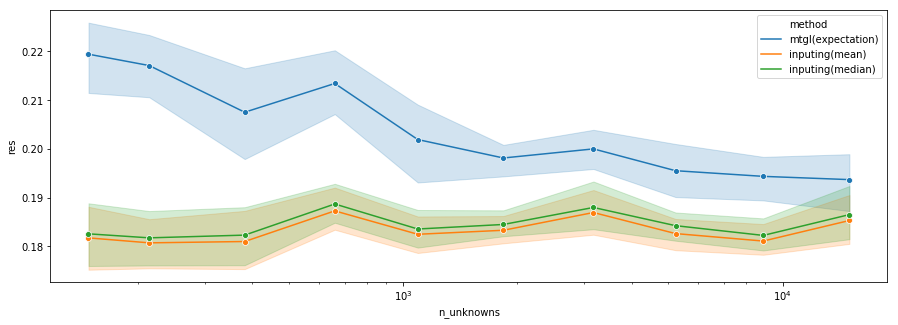

In [43]:
import pandas as pd
from regain.utils import flatten
df = pd.DataFrame(
    flatten([[(k[0], T*int(k[1] * k[1]-1) // 2 * 1, x) 
              for x in results[k]['res']] for k in results]),
    columns=['method', 'n_unknowns', 'res'])

import seaborn as sns
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(15,5))
df = df[df['method']!='mtgl(mean)']
#plt.yscale("log")
g = sns.lineplot(data=df, hue='method', x='n_unknowns', y='res', marker='o')
# g.set_yscale("log");

g.set_xscale("log");
# for k in results:
#     print(k, np.mean(results[k]['res']),  np.std(results[k]['res']))